In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import tensorly as tl
from tensorly.decomposition import parafac, parafac2, tucker
from scipy.interpolate import interp1d
import tlviz

In [12]:
matrices = []
for i in range(16):
    sheet_index = 2*i
    file_path = 'TCR_seq_new.xlsx'
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='Day').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('Day ')[1].strip() for col in tcr_counts.columns]
    tcr_counts = tcr_counts[sorted(tcr_counts.columns, key=lambda x: int(x))]
    tcr_counts = tcr_counts.where(~(tcr_counts.isna()), 0)
    matrix = tcr_counts.sort_values(by=tcr_counts.columns[0], ascending=False, kind="mergesort").head(100)
    print(matrix.shape)
    matrices.append(matrix)

(100, 15)
(100, 10)
(100, 10)
(100, 34)
(100, 3)
(100, 7)
(100, 19)
(100, 5)
(100, 5)
(100, 5)
(100, 4)
(100, 5)
(100, 4)
(100, 5)
(100, 3)
(100, 11)


In [13]:
# we drop some patients
del matrices[4]
del matrices[7]
del matrices[12]
for i in matrices:
    print (i.columns[-1])

843
186
202
951
1187
462
77
232
355
223
93
112
317


In [31]:
def interpolate_matrix(matrix, step=10):
    original_cols = np.array(matrix.columns, dtype=float)
    
    start = original_cols[0]
    end = original_cols[-1]
    target_end = math.trunc(end/10)*10
    
    target_columns = np.arange(start, target_end + step, step)
    
    matrix_values = matrix.values
    n_rows = matrix_values.shape[0]
    
    interpolated_matrix = np.zeros((n_rows, len(target_columns)))
    
    for i in range(n_rows):
        f = interp1d(original_cols, matrix_values[i], kind='linear', fill_value='extrapolate')
        interpolated_matrix[i] = f(target_columns)
    
    interpolated_df = pd.DataFrame(interpolated_matrix, index=matrix.index, columns=target_columns)
    
    return interpolated_df

In [36]:
def plotting_interpolated_df(ax, df, title):
    x_values = df.columns.astype(float)
    
    # Plot each row as a separate line
    for idx, row in df.iterrows():
        ax.plot(x_values, row, alpha=0.6, label=str(idx))
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Values")
    ax.set_title(title)
    ax.grid(True)

In [38]:
interpolated = []
for i in matrices:
    interpolated.append(interpolate_matrix(i))

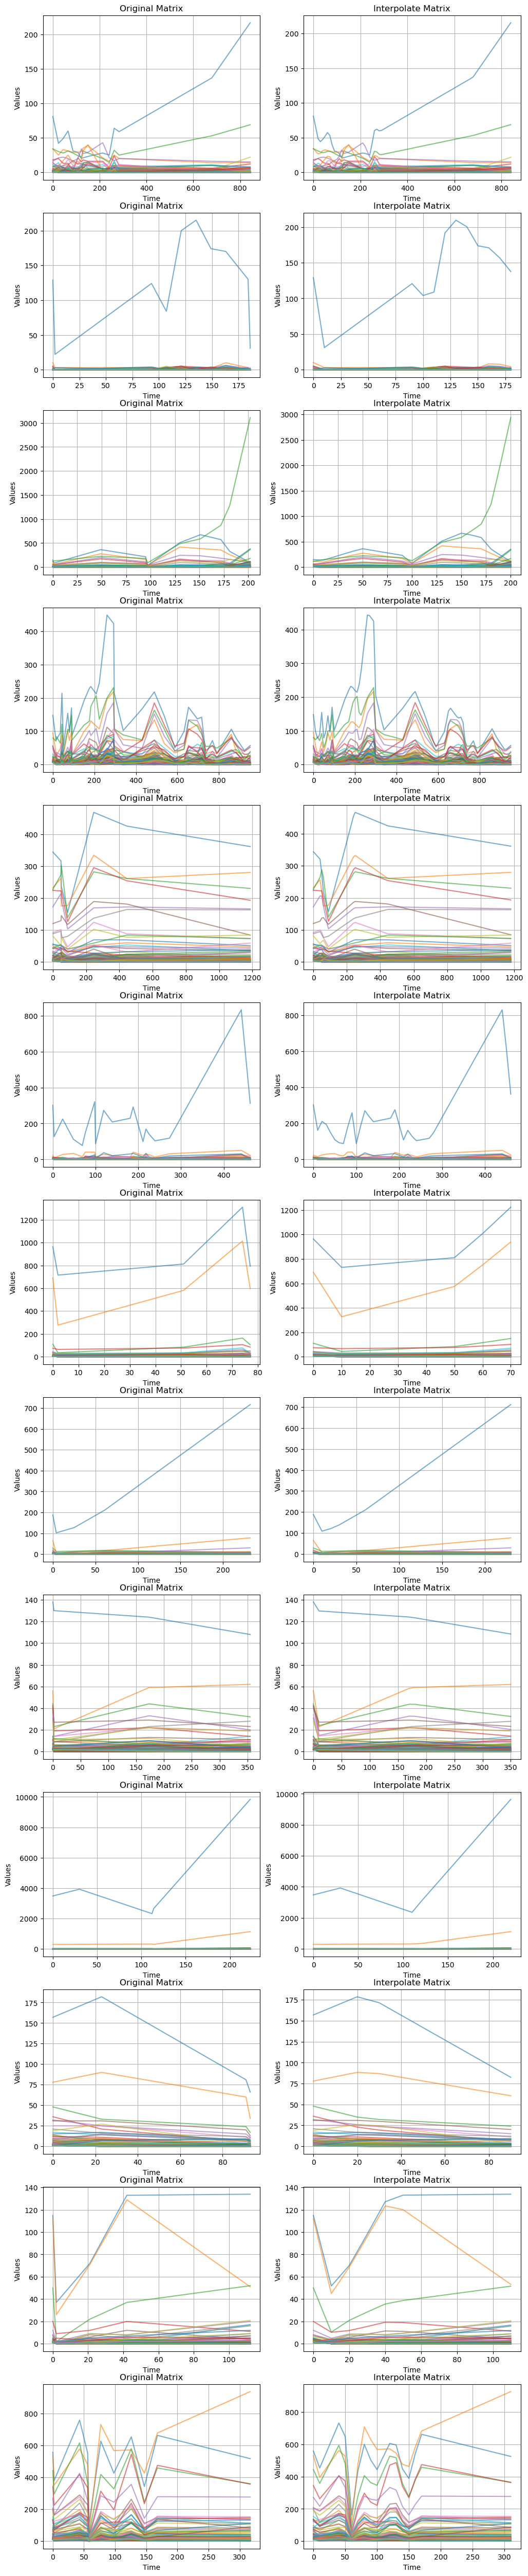

In [39]:
fig, ax = plt.subplots(13, 2, figsize=(12, 64))
for i in range(len(matrices)):
    plotting_interpolated_df(ax[i, 0], matrices[i], "Original Matrix")
    plotting_interpolated_df(ax[i, 1], interpolated[i], "Interpolate Matrix")

In [63]:
interpolated[0].sum()

0.0      374.000000
10.0     331.500000
20.0     289.000000
30.0     266.900000
40.0     258.400000
            ...    
800.0    391.682927
810.0    398.268293
820.0    404.853659
830.0    411.439024
840.0    418.024390
Length: 85, dtype: float64

In [48]:
matrices_70 = []
matrices_100 = []
matrices_200 = []
matrices_300 = []
for i in interpolated:
    if i.columns[-1] >= 70:
        matrices_70.append(i)
    if i.columns[-1] >= 100:
        matrices_100.append(i)
    if i.columns[-1] >= 200:
        matrices_200.append(i)
    if i.columns[-1] >= 300:
        matrices_300.append(i)

In [56]:
for i in range(len(matrices_70)):
    matrices_70[i] = matrices_70[i].loc[:, matrices_70[i].columns <= 70]
for i in range(len(matrices_100)):
    matrices_100[i] = matrices_100[i].loc[:, matrices_100[i].columns <= 100]
for i in range(len(matrices_200)):
    matrices_200[i] = matrices_200[i].loc[:, matrices_200[i].columns <= 200]
for i in range(len(matrices_300)):
    matrices_300[i] = matrices_300[i].loc[:, matrices_300[i].columns <= 300]

In [61]:
tensor_70 = np.stack(matrices_70, axis=-1)
tensor_100 = np.stack(matrices_100, axis=-1)
tensor_200 = np.stack(matrices_200, axis=-1)
tensor_300 = np.stack(matrices_300, axis=-1)

In [62]:
print(tensor_70.shape)
print(tensor_100.shape)
print(tensor_200.shape)
print(tensor_300.shape)

(100, 8, 13)
(100, 11, 11)
(100, 21, 9)
(100, 31, 6)
